# Volatility Clustering in Financial Time-series

Volatility clustering refers to the tendency of financial markets to experience periods of high volatility followed by periods of low volatility. This phenomenon is observed in many financial markets and is characterized by the fact that large changes in prices or returns are followed by more large changes, while small changes are followed by more small changes. In other words, the volatility of financial markets tends to be autocorrelated over time.

One reason for volatility clustering is that market participants often react to news and events in a similar way, which can amplify the effects of market shocks.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.5 MB/s eta 0:00:00


In [10]:
import time
import datetime as dt

import numpy as np
import pandas as pd
import math
import scipy as sc

from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

In [3]:
end = dt.datetime.now()
start = end - dt.timedelta(days=7777)

data = pdr.get_data_yahoo('^GSPC', start, end)
df = data.copy()
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-28,1133.280029,1138.630005,1126.660034,1133.060059,1133.060059,1186800000
2002-01-29,1133.060059,1137.469971,1098.739990,1100.640015,1100.640015,1812000000
2002-01-30,1100.640015,1113.790039,1081.660034,1113.569946,1113.569946,2019600000
2002-01-31,1113.569946,1130.209961,1113.300049,1130.199951,1130.199951,1557000000
2002-02-01,1130.199951,1130.199951,1118.510010,1122.199951,1122.199951,1367200000
...,...,...,...,...,...,...
2023-05-08,4136.979980,4142.299805,4123.810059,4138.120117,4138.120117,3641640000
2023-05-09,4124.250000,4130.350098,4116.649902,4119.169922,4119.169922,3810140000
2023-05-10,4143.740234,4154.279785,4098.919922,4137.640137,4137.640137,4057160000


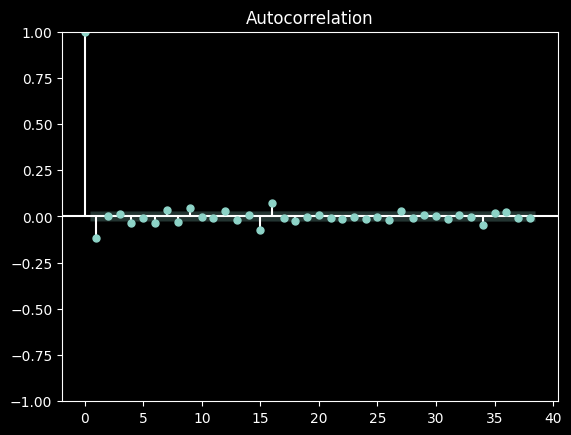

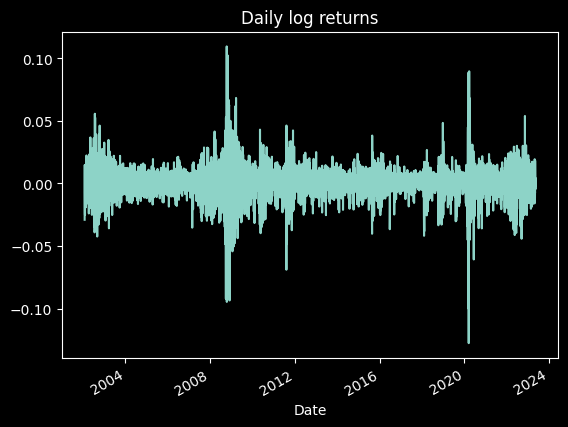

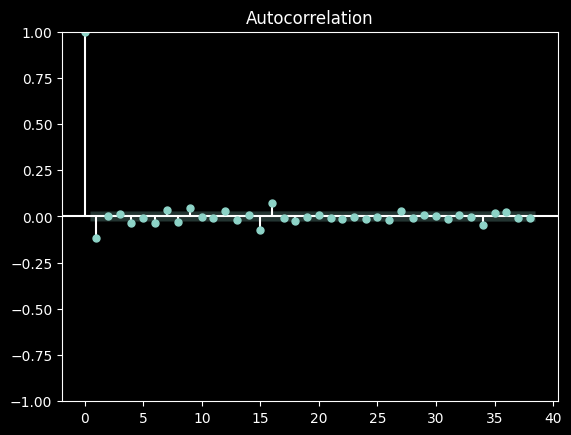

In [18]:
log_rtns = np.log((df.Close/df.Close.shift(1)).dropna())
log_rtns.plot()
plt.title('Daily log returns')
plot_acf(log_rtns)

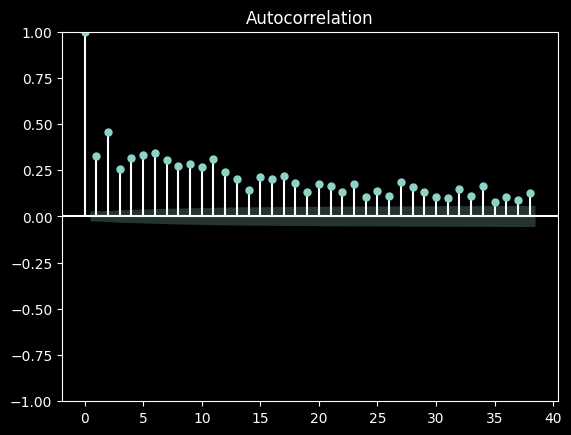

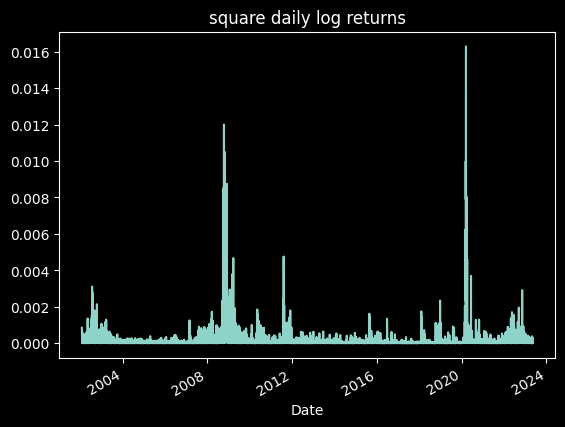

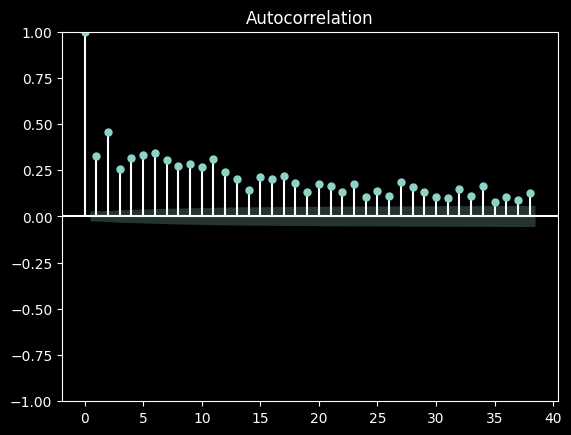

In [17]:
log_rtns_sq = np.square(log_rtns)
log_rtns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_rtns_sq)

<AxesSubplot: xlabel='Date'>

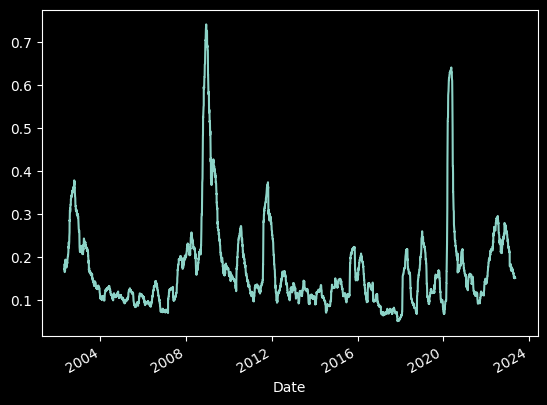

In [20]:
TRADE_DAYS = 60
vol = log_rtns.rolling(window=TRADE_DAYS).std()*np.sqrt(252)
vol = vol.dropna()
vol.plot()

# Ornstein-Uhlbeck
It is a stochastic process that is a stationary Gauss-Markov process, with $dX_t = -\kappa X_t dT + \sigma dW_t$, which may vary to the Vasicek model with an additional drift (average value $\theta$): $dX_t = \kappa(\theta - X_t)dt + \sigma dW_t$
This will lead to find that 
* $\hat{\mu}(x) = moyenne$
* $var = \frac{1}{n} \Sigma^n _{i=1}(x_i - moyenne)^2$

The MLE of Ornstein-Uhlenbeck process would be
* $X_t \sim N(\mu, \overline{\sigma})$  
* $E[X_{t+\delta t}] = X_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
* $var[X_{t+\delta t}] = \frac{\sigma ^2}{2\kappa}(1 - e^{-2\kappa \delta t})$

In [22]:
mu = 5
sigma = 2.5
N = 10000
np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))
mu_hat = np.mean(x)
var = np.var(x)

print(f'mu hat would be: {round(mu_hat, 3)}')
print(f'variance value would be: {round(var, 3)}')

mu hat would be: 4.954
variance value would be: 6.095


In [24]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]
    
    x_dt = x[1:]
    x_t = x[:-1]
    
    dt = 1/252
    
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )
    
    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

vol = np.array(vol)

cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)

kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.15


## Simulation of Ornstein-Uhlenbeck process

$dX_t = \kappa (\theta - X_t)dt + \sigma dW_t$ is tranformed, in continuous-time stochastic process: $X_t = X_0e^{-\kappa t} + \sigma \int_{0}^{t} e^{-\kappa (t-s)dW_s}$

Text(0.5, 0, 'Volatility')

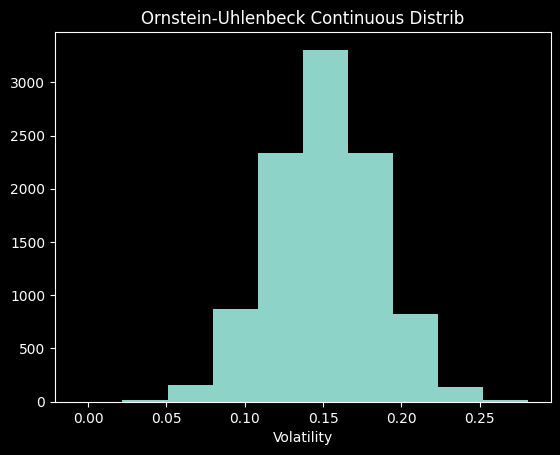

In [26]:
Time = 0.2
M = 10000
Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU * Z

plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distrib')
plt.xlabel('Volatility')


Execution time 0.0074312686920166016


Text(0, 0.5, 'Volatility')

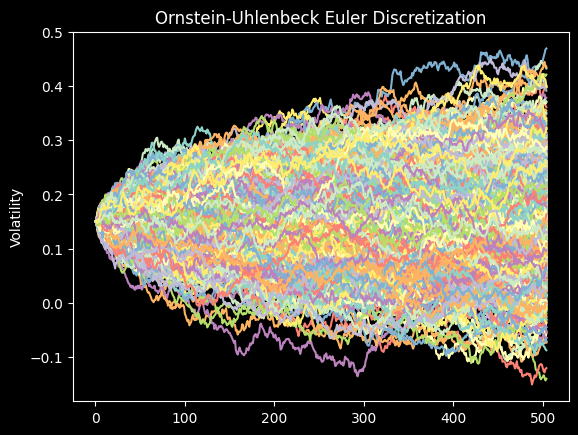

In [30]:
days = 1
years = 2
dt = days/252
M = 1000
N = int(years/dt)

vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)

vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')